In [1]:
import torch
torch.cuda.is_available()

True

## Depth -> pos using camera 

In [2]:
from core.options import AllConfigs 
from core.provider_objaverse import ObjaverseDataset as Dataset
import tyro
import time
import random

import torch
from core.options import AllConfigs
# from core.models import LGM
from core.models_fix_pretrained import LGM
from accelerate import Accelerator, DistributedDataParallelKwargs
from safetensors.torch import load_file

import kiui

from ipdb import set_trace as st
import os
import json
import re
import glob 
import shutil
from tqdm import tqdm
import numpy as np
import sys



/mnt/kostas-graid/sw/envs/xuyimeng/anaconda3/envs/lgm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/xuyimeng/Repo/LGM/core/attention.py:22: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")


In [3]:


data_path="/mnt/kostas-graid/sw/envs/chenwang/workspace/lrm-zero123/assets/9000-9999"
scene_name_pattern = os.path.join(data_path, '*')
scene_dirs = sorted(glob.glob(scene_name_pattern))
for i, scene_path in enumerate(scene_dirs):
    if i > 3:
        break
    scene_name = scene_path.split('/')[-2] if scene_path.endswith('/') else scene_path.split('/')[-1]
    print(scene_name)


0047fa5e44334d3e9bd171ad2bf95ff5
00e90648c8b94d0b9ea8a92858bd8e73
0121bb935b0641bf9733b41be191e5b5
01529e7c8d7842c498f28a9d5927a0d6


In [4]:


 # Filter out the --f argument if it's passed
filtered_args = ["big"]
# filtered_args += [arg for arg in sys.argv if not arg.startswith('--f=')]
# print(filtered_args)

opt = tyro.cli(AllConfigs, args=filtered_args)
# print(opt)

 # training 
train_dataset = Dataset(opt, name=scene_path, training=True)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=opt.batch_size,
    shuffle=False,
    # num_workers=opt.num_workers,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
)

In [5]:

for i, data in enumerate(train_dataloader):
    if i > 1 :
        break
    print(data.keys())
    print(data['cam_pos'].shape)
    print(data['cam_view'].shape)

    # use cam pos for projection
    print(data['cam_view_proj'])


dict_keys(['images_output', 'masks_output', 'input', 'c2w', 'cam_view', 'cam_view_proj', 'cam_pos', 'vids'])
torch.Size([1, 8, 3])
torch.Size([1, 8, 4, 4])
tensor([[[[ 2.1892e+00, -1.6311e-08, -2.2352e-08, -1.4901e-08],
          [-4.8611e-16, -2.1892e+00,  4.4703e-08,  2.9802e-08],
          [ 1.6311e-08, -4.0778e-09, -1.5000e+00, -1.0000e+00],
          [ 8.1555e-09,  1.3049e-07,  1.6250e+00,  1.5000e+00]],

         [[ 1.0946e+00, -6.4845e-01, -1.2207e+00, -8.1380e-01],
          [ 9.4797e-01, -1.5944e+00,  7.9668e-01,  5.3112e-01],
          [-1.6419e+00, -1.3528e+00, -3.5383e-01, -2.3589e-01],
          [ 1.2145e-07, -1.1231e-07,  1.6250e+00,  1.5000e+00]],

         [[-1.0946e+00,  9.4797e-01, -1.1250e+00, -7.5000e-01],
          [ 9.4797e-01, -1.3683e+00, -9.7428e-01, -6.4952e-01],
          [-1.6419e+00, -1.4219e+00,  1.8750e-01,  1.2500e-01],
          [-1.9485e-07,  2.6984e-08,  1.6250e+00,  1.5000e+00]],

         [[-2.1892e+00, -2.1728e-08,  2.0072e-08,  1.3381e-08],
      

In [22]:
cam_index = 2
cam_view = data['cam_view'][:,cam_index] # choose one cam
cam_poses = data['c2w'][:,cam_index] # choose one cam
cam_view.shape, cam_poses.shape
# cam_poses[:, :3, 1:3] *= -1
cam_poses_neg = cam_poses.clone()
cam_poses_neg[:, :3, 1:3] *= -1

cam_view2 = torch.inverse(cam_poses).transpose(1, 2)
cam_view3 = torch.inverse(cam_poses_neg).transpose(1, 2)
torch.allclose(cam_view, cam_view2), torch.allclose(cam_view, cam_view3)


(False, True)

In [57]:
# check whether bmm is the same as @ 
N=20
# c2w = cam_poses
c2w = cam_poses_opengl
pos = torch.rand(1,N,3)
cam_pos = torch.cat([pos,
           torch.ones((pos.shape[0], pos.shape[1], 1), device=c2w.device, dtype=torch.float32)
            ], dim=2)
pos_bmm = torch.bmm(cam_pos, c2w)
pos_bmm_transpose = torch.bmm(cam_pos, c2w.transpose(1,2))
pos_at = pos @ c2w[:, :3, :3].transpose(1,2) + c2w[:, :3, 3]
pos_left = (c2w @ cam_pos.transpose(1,2)).transpose(1,2) # pos_at = pos_left = pos_bmm_transpose
# 

In [58]:
pos_left = pos_left[...,:3] / pos_left[...,3:]
pos_left

tensor([[[ 0.2636,  0.5374, -0.9958],
         [ 0.7844,  0.7497, -0.4034],
         [ 0.8524,  0.8188, -0.3720],
         [ 0.4813,  0.3158, -1.3217],
         [ 0.7257,  0.8833, -1.2464],
         [ 1.0317,  0.7303, -0.8191],
         [ 1.0091,  0.4057, -0.9643],
         [ 0.6679,  1.0131, -1.0509],
         [ 1.2794,  0.3741, -1.0124],
         [ 0.4214,  1.2213, -0.8997],
         [ 1.0915,  0.6375, -0.9008],
         [ 0.3917,  0.3427, -1.2015],
         [ 0.3986,  0.2596, -1.4174],
         [ 1.2430,  0.5930, -1.1235],
         [ 0.0647,  0.5999, -0.6749],
         [ 1.1825,  0.6687, -1.1637],
         [ 0.2545,  0.4493, -1.0544],
         [ 0.7765,  0.8034, -0.8130],
         [ 1.1174,  0.4089, -1.1132],
         [ 0.4144,  0.4043, -0.6416]]])

In [65]:

# pos_bmm = pos_bmm[...,:3] / pos_bmm[...,3:]
# pos_bmm_transpose = pos_bmm_transpose[...,:3] / pos_bmm_transpose[...,3:]
pos_bmm, 
pos_bmm_transpose

tensor([[[ 0.2636,  0.5374, -0.9958],
         [ 0.7844,  0.7497, -0.4034],
         [ 0.8524,  0.8188, -0.3720],
         [ 0.4813,  0.3158, -1.3217],
         [ 0.7257,  0.8833, -1.2464],
         [ 1.0317,  0.7303, -0.8191],
         [ 1.0091,  0.4057, -0.9643],
         [ 0.6679,  1.0131, -1.0509],
         [ 1.2794,  0.3741, -1.0124],
         [ 0.4214,  1.2213, -0.8997],
         [ 1.0915,  0.6375, -0.9008],
         [ 0.3917,  0.3427, -1.2015],
         [ 0.3986,  0.2596, -1.4174],
         [ 1.2430,  0.5930, -1.1235],
         [ 0.0647,  0.5999, -0.6749],
         [ 1.1825,  0.6687, -1.1637],
         [ 0.2545,  0.4493, -1.0544],
         [ 0.7765,  0.8034, -0.8130],
         [ 1.1174,  0.4089, -1.1132],
         [ 0.4144,  0.4043, -0.6416]]])

In [60]:
pos_at

tensor([[[ 0.2636,  0.5374, -0.9958],
         [ 0.7844,  0.7497, -0.4034],
         [ 0.8524,  0.8188, -0.3720],
         [ 0.4813,  0.3158, -1.3217],
         [ 0.7257,  0.8833, -1.2464],
         [ 1.0317,  0.7303, -0.8191],
         [ 1.0091,  0.4057, -0.9643],
         [ 0.6679,  1.0131, -1.0509],
         [ 1.2794,  0.3741, -1.0124],
         [ 0.4214,  1.2213, -0.8997],
         [ 1.0915,  0.6375, -0.9008],
         [ 0.3917,  0.3427, -1.2015],
         [ 0.3986,  0.2596, -1.4174],
         [ 1.2430,  0.5930, -1.1235],
         [ 0.0647,  0.5999, -0.6749],
         [ 1.1825,  0.6687, -1.1637],
         [ 0.2545,  0.4493, -1.0544],
         [ 0.7765,  0.8034, -0.8130],
         [ 1.1174,  0.4089, -1.1132],
         [ 0.4144,  0.4043, -0.6416]]])

In [61]:
torch.allclose(pos_at, pos_left), torch.allclose(pos_at, pos_bmm_transpose), torch.allclose(pos_bmm, pos_left)

(True, True, False)

### check the einops consistency

In [2]:

import einops

In [3]:
B,V,H,W = 1, 6, 128, 128
depth = torch.rand([B,V,1,H,W])
depth_copy = depth.clone()
print(depth.shape)
depth = einops.rearrange(depth, 'b v c h w-> (b v) (h w) c', v=V, h=H, w=W)
depth = einops.rearrange(depth, '(b v) (h w) c-> b v c h w', v=V, h=H, w=W)

torch.allclose(depth_copy, depth)

torch.Size([1, 6, 1, 128, 128])


/mnt/kostas-graid/sw/envs/xuyimeng/anaconda3/envs/lgm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### Verify the depth_act used in the splatter image

In [1]:

import torch

In [9]:
depth = torch.rand(6,213,2)*10
depth, torch.sigmoid(depth), torch.logit(torch.sigmoid(depth)), \
torch.allclose(depth,  torch.logit(torch.sigmoid(depth)))

### Save a vis of depth

In [10]:
import torch
import kiui

In [15]:
# read ply
# Load the tensor from the file
# file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/0047fa5e44334d3e9bd171ad2bf95ff5/eval_pred_gs_600_0/raw_splatter_out_tensor.pt'
# file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/0047fa5e44334d3e9bd171ad2bf95ff5/eval_pred_gs_1100_0_es/raw_splatter_out_tensor.pt'
# file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/0047fa5e44334d3e9bd171ad2bf95ff5/eval_pred_gs_0_0/raw_splatter_out_tensor.pt'
# file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/01529e7c8d7842c498f28a9d5927a0d6/eval_pred_gs_1410_0_es/raw_splatter_out_tensor.pt'
file_path = 'runs/LGM_optimize_splatter/debug2/00013-depth_offset-es10-Plat-patience_20-factor_0.5-eval_5-adamW-subset_0_-1_splat128-inV6-lossV20-lr0.006/9000-9999/00e90648c8b94d0b9ea8a92858bd8e73/eval_pred_gs_1999_0/raw_splatter_out_tensor.pt'
loaded_tensor = torch.load(file_path)

print(loaded_tensor.shape)
# get_depth and xyz offset from world pos

torch.Size([1, 6, 15, 128, 128])


In [16]:

# B, V, C, H, W = loaded_tensor.shape
# for b in range(B):
#     for v in range(V):       
#         depth = loaded_tensor[b, v, 14:,... ]
#         depth = depth.permute(1,2,0)
#         print(depth.shape)
#         kiui.write

depth = loaded_tensor[:,:,14:] 
print(depth.min(), depth.max(), depth.mean(), depth.median())
d_min, d_max = depth.min(), depth.max()
# d_min, d_max = 0.5, 2
depth = (depth - d_min) / (d_max - d_min)
gt_images = depth.detach().cpu().numpy() # [B, V, 3, output_size, output_size]
gt_images = gt_images.transpose(0, 3, 1, 4, 2).reshape(-1, gt_images.shape[1] * gt_images.shape[3], 1) # [B*output_size, V*output_size, 3]
kiui.write_image('depth_epoch0.jpg', gt_images)
        

tensor(0.0626, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.8616, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>) tensor(1.0237, device='cuda:0', grad_fn=<MedianBackward0>)


In [18]:
opacity = loaded_tensor[:,:, 3:4] 
print(opacity.min(), opacity.max(), opacity.mean(), opacity.median())
# d_min, d_max = opacity.min(), opacity.max()

d_min, d_max = -15, 5
depth = (opacity - d_min) / (d_max - d_min)
depth = 1 - depth.clamp(0,1)
gt_images = depth.detach().cpu().numpy() # [B, V, 3, output_size, output_size]
gt_images = gt_images.transpose(0, 3, 1, 4, 2).reshape(-1, gt_images.shape[1] * gt_images.shape[3], 1) # [B*output_size, V*output_size, 3]
kiui.write_image('opacity_epoch_bucket.jpg', gt_images)

tensor(-8.8490, device='cuda:0', grad_fn=<MinBackward1>) tensor(5.3397, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-3.2277, device='cuda:0', grad_fn=<MeanBackward0>) tensor(-4.3725, device='cuda:0', grad_fn=<MedianBackward0>)


(128, 768, 1) (128, 768, 1, 4)


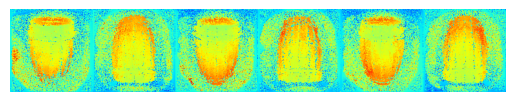

In [17]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm

depth_colormap = cm.jet(gt_images)  # This will produce an RGBA image
print(gt_images.shape, depth_colormap.shape)
# Remove the alpha channel
depth_colormap = depth_colormap[..., 0, :3]
plt.imsave('depth_colormap_birdman.png', depth_colormap)

# If you need to display the colorized depth map instead of saving it
plt.imshow(depth_colormap)
plt.axis('off')  # Disable axis
plt.show()